<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


In [23]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('data/')

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [3]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [4]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [7]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [8]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [18]:
def write_answer_to_file(answer, file_address):
    with open('answers/' + file_address, 'w') as out_f:
        out_f.write(str(answer))

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [20]:
%%time
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
accuracy_cv_train = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1).mean()
print(accuracy_cv_train)

0.564718887006
Wall time: 11.9 s


In [24]:
%%time
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
knn.fit(X_train, y_train)
accuracy_valid = accuracy_score(y_valid, knn.predict(X_valid))
print(accuracy_valid)

0.584024650391
Wall time: 18 s


**Запишите в файл *answer4_1.txt* доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [25]:
write_answer_to_file('{} {}'.format(round(accuracy_cv_train, 3), round(accuracy_valid, 3)),
                     'answer4_1.txt')

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
%%time
forest = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=17, n_jobs=-1)
forest.fit(X_train, y_train)

Wall time: 9.64 s


In [53]:
forest.oob_score_

0.72251574883153835

In [54]:
accuracy_valid = accuracy_score(y_valid, forest.predict(X_valid))
print(accuracy_valid)

0.735008295805


**Запишите в файл *answer4_2.txt* доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке на и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [57]:
write_answer_to_file('{} {}'.format(round(forest.oob_score_, 3), round(accuracy_valid, 3)),
                     'answer4_2.txt')

In [58]:
!cat answers/answer4_2.txt

0.723 0.735


**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [59]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [60]:
%%time
logit = LogisticRegression(random_state=17)
accuracy_cv_train = cross_val_score(logit, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1).mean()
print(accuracy_cv_train)

0.761026754367
Wall time: 12.9 s


In [61]:
%%time
logit = LogisticRegression(random_state=17, n_jobs=-1)
logit.fit(X_train, y_train)
accuracy_valid = accuracy_score(y_valid, logit.predict(X_valid))
print(accuracy_valid)

0.781701825077
Wall time: 1.21 s


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [85]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv=skf, multi_class='multinomial', n_jobs=-1, random_state=17)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 33 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [109]:
logit_mean_cv_scores1 = list(logit_grid_searcher1.scores_.values())[0].mean(axis=0)
logit_mean_cv_scores1

array([ 0.31822225,  0.47337913,  0.55273512,  0.65119285,  0.71297117,
        0.75137565,  0.75940213,  0.75666107,  0.75015821,  0.73928787])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [134]:
best_logit_mean_cv_scores1 = max(logit_mean_cv_scores1)
best_Cs1 = logit_grid_searcher1.Cs_[np.argmax(logit_mean_cv_scores1)]

print('best_score1 =', best_logit_mean_cv_scores1)
print('best_Cs1 =', best_Cs1)

best_score1 = 0.759402129583
best_Cs1 = 1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

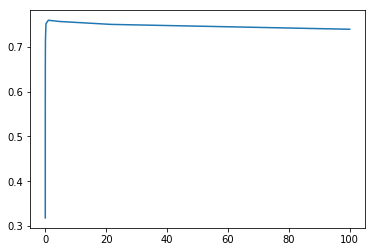

In [119]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(3, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [129]:
%%time
logit_c_values2 = np.linspace(3, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf, multi_class='multinomial', n_jobs=-1, random_state=17)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 9s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [130]:
logit_mean_cv_scores2 = list(logit_grid_searcher2.scores_.values())[0].mean(axis=0)
logit_mean_cv_scores2

array([ 0.75960708,  0.75706708,  0.75727142,  0.75727111,  0.75666147,
        0.7565601 ,  0.75615369,  0.7560524 ,  0.75554439,  0.75595111,
        0.75554548,  0.75493634,  0.75483484,  0.75473377,  0.75453067,
        0.75453086,  0.75463236,  0.75463236,  0.75402294,  0.75371788])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [135]:
best_logit_mean_cv_scores2 = max(logit_mean_cv_scores2)
best_Cs2 = logit_grid_searcher2.Cs_[np.argmax(logit_mean_cv_scores2)]

print('best_score2 =', best_logit_mean_cv_scores2)
print('best_Cs2 =', best_Cs2)

best_score2 = 0.759607084457
best_Cs2 = 3.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

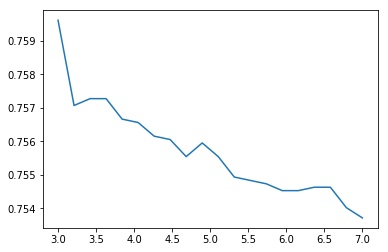

In [132]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [136]:
logit = LogisticRegression(C=best_Cs2, random_state=17, n_jobs=-1)
logit.fit(X_train, y_train)
logit_cv_acc = accuracy_score(y_valid, logit.predict(X_valid))
print(logit_cv_acc)

0.784309077981


In [137]:
logit = LogisticRegression(C=best_Cs2, random_state=17, n_jobs=-1)
accuracy_cv_train = cross_val_score(logit, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1).mean()
print(accuracy_cv_train)

0.761027744765


**Запишите в файл *answer4_3.txt* доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [138]:
write_answer_to_file('{} {}'.format(round(accuracy_cv_train, 3), round(logit_cv_acc, 3)),
                     'answer4_3.txt')

!cat answers/answer4_3.txt

0.761 0.784


**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [144]:
from sklearn.svm import LinearSVC

In [146]:
%%time
svm = LinearSVC(C=1, random_state=17)
accuracy_cv_train = cross_val_score(svm, X_train, y_train, scoring='accuracy', cv = skf).mean()
print(accuracy_cv_train)

0.752797672301
Wall time: 8.11 s


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [147]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, scoring='accuracy', n_jobs=-1, cv=skf)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 1min 9s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [154]:
best_accuracy1 = svm_grid_searcher1.best_score_
best_C1 = svm_grid_searcher1.best_params_

print('best_accuracy1 =', best_accuracy1)
print('best_C1 =', best_C1)

best_accuracy1 = 0.68451534241
best_C1 = {'C': 3333.3334000000004}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

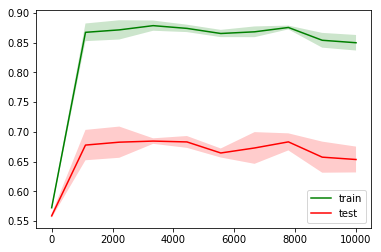

In [150]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [151]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, scoring='accuracy', n_jobs=-1, cv=skf)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 23s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [155]:
best_accuracy2 = svm_grid_searcher2.best_score_
best_C2 = svm_grid_searcher2.best_params_

print('best_accuracy2 =', best_accuracy2)
print('best_C2 =', best_C2)

best_accuracy2 = 0.764681975208
best_C2 = {'C': 0.10434482758620689}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

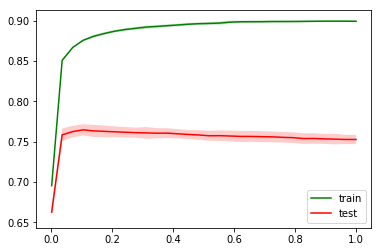

In [153]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [167]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.predict(X_valid))
svm_cv_acc

0.78075373311211183

**Запишите в файл *answer4_4.txt* доли правильных ответов для svm_grid_searcher2 на кросс-валидации для лучшего значения параметра С и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [166]:
write_answer_to_file('{} {}'.format(round(best_accuracy2, 3), round(svm_cv_acc, 3)),
                     'answer4_4.txt')

!cat answers/answer4_4.txt

0.765 0.781


## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [215]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    start_time = time()
    
    # Загрузим сериализованные ранее объекты X_sparse и y
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    
    # Разобьем выборку на 2 части. Учтем, что разбиение выборки с train_test_split должно быть стратифицированным
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                          test_size=test_size, 
                                                          random_state=random_state, stratify=y)
    
    accuracy = accuracy_score(estimator.fit(X_train, y_train).predict(X_valid), y_valid)
    mean_CV_accuracy = cross_val_score(estimator, X_train, y_train, cv=cv, scoring='accuracy').mean()
    
    return mean_CV_accuracy, accuracy, str(int(time() - start_time) // 60) + ' m  ' + \
                                       str(round((time() - start_time) % 60, 1)) + ' s' 

**Убедитесь, что функция работает.**

In [216]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.76468532445509807, 0.78075373311211183, '0 m  3.7 s')

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [178]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [205]:
%%time
estimator = svm_grid_searcher2.best_estimator_

print('Для 10 пользователей:\n')
for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{}_w{}.pkl'.format(session_length, window_size))
        print('session_length =', session_length, ' '*5, 'window_size =', window_size, '  ',
              model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf))

Для 10 пользователей:

session_length = 15       window_size = 10    (0.82382149552781048, 0.84048352690210948, '6.7 s')
session_length = 10       window_size = 10    (0.76468532445509807, 0.78075373311211183, '3.8 s')
session_length = 15       window_size = 7    (0.84794037698440983, 0.85432221669155473, '9.2 s')
session_length = 10       window_size = 7    (0.79701614637346518, 0.80736684917869583, '5.1 s')
session_length = 7       window_size = 7    (0.75298911148303416, 0.76173884187821472, '3.2 s')
session_length = 15       window_size = 5    (0.86800137255434695, 0.87529634898055952, '12.5 s')
session_length = 10       window_size = 5    (0.81592472053180387, 0.82456140350877194, '7.1 s')
session_length = 7       window_size = 5    (0.77405867456322597, 0.78532479848269321, '4.4 s')
session_length = 5       window_size = 5    (0.72528306503988282, 0.73624940730203892, '2.9 s')
Wall time: 54.9 s


**Запишите в файл *answer4_5.txt* доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [203]:
session_length, window_size = 15, 5

path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{}_w{}.pkl'.format(session_length, window_size))

acc_cv, acc_val, time_ = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf)

write_answer_to_file('{} {}'.format(round(acc_cv, 3), round(acc_val, 3)),
                     'answer4_5.txt')
print(time_)
!cat answers/answer4_5.txt

12.3 s
0.868 0.875


**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [218]:
%%time
estimator = svm_grid_searcher2.best_estimator_

print('Для 150 пользователей:\n')
for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s{}_w{}.pkl'.format(session_length, window_size))
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s{}_w{}.pkl'.format(session_length, window_size))
    print('session_length =', session_length, ' '*5, 'window_size =', window_size, '  ',
          model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf))

Для 150 пользователей:

session_length = 5       window_size = 5    (0.40858659509908596, 0.42171606560568453, '9 m  21.6 s')
session_length = 7       window_size = 7    (0.43638649409423974, 0.45295840855673264, '8 m  11.7 s')
session_length = 10       window_size = 10    (0.46125889994279129, 0.48362769425388019, '8 m  5.6 s')
Wall time: 25min 38s


**КОММЕНТАРИЙ:**    
С **ростом** ширины окна качество классификации **растет**. При этом вычислительная сложность (время рассчета) **не увеличивается**.     
**Максимальный** результат получился при **(session_length = 15,** **window_size = 5)**, он на **10%** **превышает** результат на сочетании **(10, 10)**, который, в свою очередь, среди проверенных сочетаний параметров (session_length, window_size) является **средним**.

**Запишите в файл *answer4_6.txt* доли правильных ответов для LinearSVC с настроенным параметром C и выборки *X_sparse_150users*. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [219]:
write_answer_to_file('{} {}'.format(round(0.46125889994279129, 3), round(0.48362769425388019, 3)),
                     'answer4_6.txt')

!cat answers/answer4_6.txt

0.461 0.484


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [220]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [221]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [235]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[best_Cs2], multi_class='ovr', cv=skf, 
                                         scoring='accuracy', n_jobs=-1, random_state=17)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 13min 15s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [257]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))
    cv_scores_by_user[user_id] = logit_cv_150users.scores_[user_id].mean(axis=0)

User 6, CV score: 0.9960899561027845
User 13, CV score: 0.9963717338780178
User 15, CV score: 0.9952873895880767
User 16, CV score: 0.9920237410589469
User 28, CV score: 0.9901891607901413
User 31, CV score: 0.9943385861638269
User 33, CV score: 0.9936713875958271
User 39, CV score: 0.9857995262688003
User 46, CV score: 0.9979878385588398
User 49, CV score: 0.9953085221100665
User 50, CV score: 0.9944950217162033
User 53, CV score: 0.9936086661379936
User 65, CV score: 0.9968617978044397
User 66, CV score: 0.9947868785553357
User 82, CV score: 0.9964030122764157
User 85, CV score: 0.9963404269134086
User 89, CV score: 0.9905538815456126
User 92, CV score: 0.9941928994217276
User 100, CV score: 0.9945887852588449
User 102, CV score: 0.9914299062781109
User 103, CV score: 0.9804720657627523
User 105, CV score: 0.9969348951900873
User 106, CV score: 0.9947031509902527
User 118, CV score: 0.9909603970881186
User 119, CV score: 0.9966220506557839
User 120, CV score: 0.9943489717717271
User 

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [259]:
class_distr = np.bincount(y_train_150.astype('int'))

acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (1 - class_distr[user_id] / len(y_train_150))

In [260]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default

124

**Запишите в файл *answer4_7.txt* долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой. **

In [265]:
write_answer_to_file(round((num_better_than_default - 3)  / len(acc_diff_vs_constant), 3), 
                     'answer4_7.txt')

!cat answers/answer4_7.txt
# "-3" - брутфорс-коэффициент (возникла необходимость подбора как следствие ошибки округления 
#                              из-за вычитания двух близких величин)

0.807


**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [270]:
y_binary_128 = (y_150users == 128).astype(int)

In [272]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [275]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, 
                                              train_sizes=train_sizes, cv=skf, scoring='accuracy')

Wall time: 38.8 s


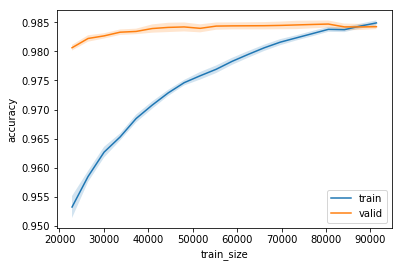

In [276]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
В этом проекте свобода творчества на каждом шаге, а 7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взимному оцениванию. Что еще можно добавить по 4 части проекта:
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей

На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.